In [4]:
import pandas as pd
import numpy as np
from itertools import product

# Fungsi untuk menghasilkan semua kombinasi kartu yang mungkin
def generate_all_cards():
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
    suits = ['♠', '♥', '♦', '♣']
    return [f"{rank}{suit}" for rank, suit in product(ranks, suits)]

# Fungsi untuk menghitung kekuatan tangan
def hand_strength(card1, card2):
    ranks = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
    # Perbaikan: menggunakan split untuk memisahkan rank dan suit
    rank1, suit1 = card1[:-1], card1[-1]
    rank2, suit2 = card2[:-1], card2[-1]
    rank1_value, rank2_value = ranks[rank1], ranks[rank2]
    suited = suit1 == suit2
    return (max(rank1_value, rank2_value) * 14 + min(rank1_value, rank2_value)) + (5 if suited else 0)

# Fungsi untuk menghasilkan dataset
def generate_poker_dataset(n_samples):
    all_cards = generate_all_cards()
    positions = ['BTN', 'SB', 'BB', 'UTG', 'MP', 'CO']

    data = {
        'hole_card_1': [],
        'hole_card_2': [],
        'position': [],
        'players_left': [],
        'pot_size': [],
        'bet_to_call': [],
        'hand_strength': [],
        'win': []
    }

    for _ in range(n_samples):
        # Menghasilkan dua kartu unik
        card1, card2 = np.random.choice(all_cards, size=2, replace=False)
        position = np.random.choice(positions)
        players_left = np.random.randint(2, 10)
        pot_size = np.random.randint(10, 1000)
        bet_to_call = np.random.randint(0, pot_size // 2)
        strength = hand_strength(card1, card2)

        data['hole_card_1'].append(card1)
        data['hole_card_2'].append(card2)
        data['position'].append(position)
        data['players_left'].append(players_left)
        data['pot_size'].append(pot_size)
        data['bet_to_call'].append(bet_to_call)
        data['hand_strength'].append(strength)

        # Simulasi hasil (win/lose) berdasarkan kekuatan tangan dan faktor acak
        win_probability = (strength / 200) * (1 - bet_to_call / pot_size) * (1 / players_left)
        data['win'].append(1 if np.random.random() < win_probability else 0)

    return pd.DataFrame(data)

# Menghasilkan dataset
n_samples = 100000  # Jumlah sampel yang diinginkan
df = generate_poker_dataset(n_samples)

# Menyimpan dataset ke file CSV
df.to_csv('poker_dataset.csv', index=False)

# Menampilkan informasi tentang dataset
print("Informasi Dataset:")
print(df.info())

print("\nStatistik Deskriptif:")
print(df.describe())

print("\nDistribusi Kemenangan:")
print(df['win'].value_counts(normalize=True))

print("\nContoh 5 Baris Pertama:")
print(df.head())

print(f"\nDataset dengan {n_samples} sampel telah disimpan sebagai 'poker_dataset.csv'")

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   hole_card_1    100000 non-null  object
 1   hole_card_2    100000 non-null  object
 2   position       100000 non-null  object
 3   players_left   100000 non-null  int64 
 4   pot_size       100000 non-null  int64 
 5   bet_to_call    100000 non-null  int64 
 6   hand_strength  100000 non-null  int64 
 7   win            100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB
None

Statistik Deskriptif:
        players_left       pot_size    bet_to_call  hand_strength  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        5.498280     505.150990     125.615910     149.720160   
std         2.292394     285.901127     109.908288      44.079853   
min         2.000000      10.000000       0.000000      30.000000   
25%      

Akurasi: 0.8651

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     17451
           1       0.29      0.04      0.07      2549

    accuracy                           0.87     20000
   macro avg       0.59      0.51      0.50     20000
weighted avg       0.80      0.87      0.82     20000



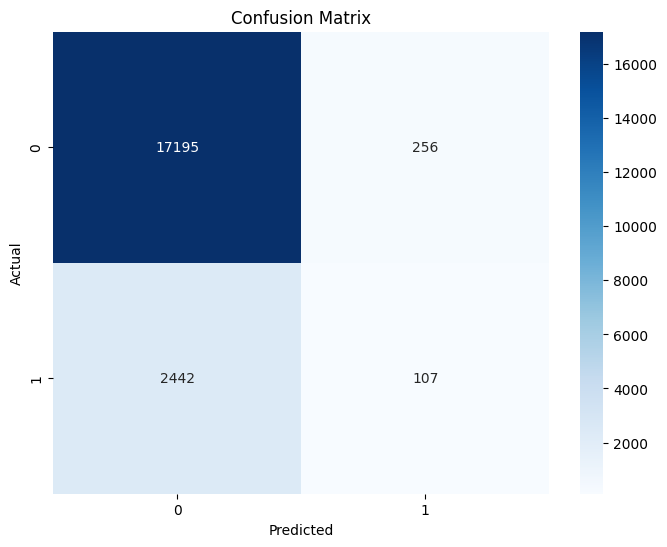

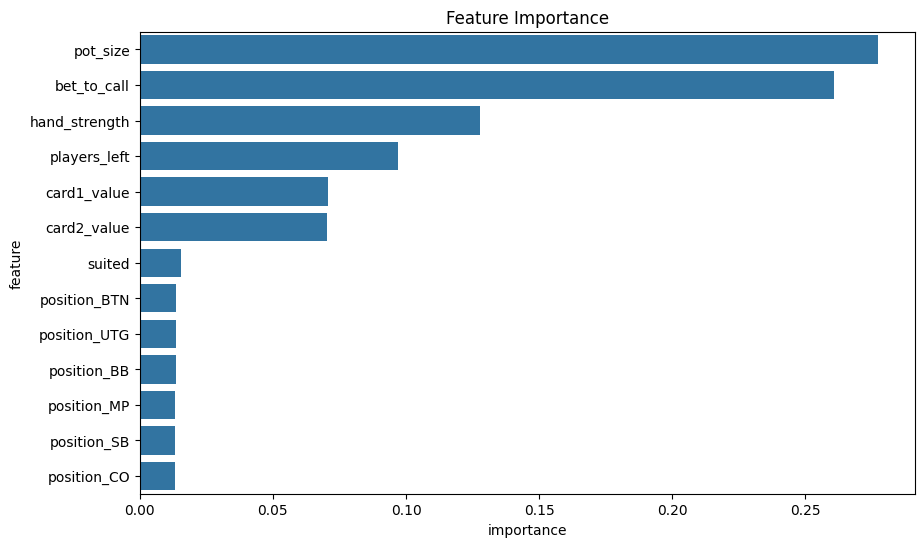


Probabilitas kemenangan untuk AsKs di posisi BTN: 0.2700


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Memuat dataset
df = pd.read_csv('poker_dataset.csv')

# Preprocessing
def card_to_value(card):
    ranks = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
    rank = card[:-1]  # Mengambil semua karakter kecuali yang terakhir sebagai rank
    return ranks[rank]

df['card1_value'] = df['hole_card_1'].apply(card_to_value)
df['card2_value'] = df['hole_card_2'].apply(card_to_value)
df['suited'] = (df['hole_card_1'].str[-1] == df['hole_card_2'].str[-1]).astype(int)

# One-hot encoding untuk posisi
df = pd.get_dummies(df, columns=['position'])

# Memilih fitur dan target
features = ['card1_value', 'card2_value', 'suited', 'players_left', 'pot_size', 'bet_to_call', 'hand_strength'] + [col for col in df.columns if col.startswith('position_')]
X = df[features]
y = df['win']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Membuat prediksi
y_pred = rf_model.predict(X_test_scaled)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi: {accuracy:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Pentingnya Fitur
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Fungsi untuk memprediksi kemenangan
def predict_win_probability(card1, card2, position, players_left, pot_size, bet_to_call):
    # Preprocessing input
    card1_value = card_to_value(card1)
    card2_value = card_to_value(card2)
    suited = int(card1[-1] == card2[-1])
    hand_strength = max(card1_value, card2_value) * 14 + min(card1_value, card2_value) + (5 if suited else 0)

    # Membuat DataFrame untuk input dengan semua fitur yang digunakan saat pelatihan
    input_data = pd.DataFrame(columns=features)
    input_data.loc[0] = 0  # Inisialisasi semua nilai dengan 0

    # Mengisi nilai-nilai yang kita ketahui
    input_data.loc[0, 'card1_value'] = card1_value
    input_data.loc[0, 'card2_value'] = card2_value
    input_data.loc[0, 'suited'] = suited
    input_data.loc[0, 'players_left'] = players_left
    input_data.loc[0, 'pot_size'] = pot_size
    input_data.loc[0, 'bet_to_call'] = bet_to_call
    input_data.loc[0, 'hand_strength'] = hand_strength
    input_data.loc[0, f'position_{position}'] = 1

    # Normalisasi input
    input_scaled = scaler.transform(input_data)

    # Membuat prediksi
    win_probability = rf_model.predict_proba(input_scaled)[0][1]
    return win_probability

# Contoh penggunaan
card1 = 'As'  # As (Ace of spades)
card2 = 'Ks'  # Ks (King of spades)
position = 'BTN'
players_left = 6
pot_size = 100
bet_to_call = 20

win_prob = predict_win_probability(card1, card2, position, players_left, pot_size, bet_to_call)
print(f"\nProbabilitas kemenangan untuk {card1}{card2} di posisi {position}: {win_prob:.4f}")